<a href="https://colab.research.google.com/github/maximum4645/Garbage_Classification/blob/main/exp3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import torch
import torchvision.transforms as transforms
import torchvision
import torchvision.models as models
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision.transforms.functional import adjust_sharpness
import matplotlib.pyplot as plt
import numpy as np

# Data

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download and extract the dataset
dataset_zip = 'garbage-classification.zip'
base_dir = './Garbage_Classification'
data_dir = os.path.join(base_dir, 'Garbage classification/Garbage classification')

if not os.path.exists(data_dir):
    print("Downloading Garbage Classification dataset...")
    !kaggle datasets download -d asdasdasasdas/garbage-classification -p .
    print("Extracting dataset...")
    !unzip -q garbage-classification.zip -d {base_dir}
    os.remove(dataset_zip)
    print("Download and extraction complete!")
else:
    print("Dataset already exists. Skipping download.")

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
 91% 75.0M/82.0M [00:00<00:00, 129MB/s] 
100% 82.0M/82.0M [00:00<00:00, 112MB/s]
Extracting dataset...
Download and extraction complete!


In [5]:
# Define transformations for normalization and data augmentation
train_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Lambda(lambda img: adjust_sharpness(img, sharpness_factor=2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Lambda(lambda img: adjust_sharpness(img, sharpness_factor=2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset using ImageFolder
dataset = ImageFolder(root=data_dir)

# Split into training and testing datasets
train_idx, test_idx = train_test_split(
    list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets
)

train_set = torch.utils.data.Subset(dataset, train_idx)
test_set = torch.utils.data.Subset(dataset, test_idx)

# Apply transformations
train_set.dataset.transform = train_transform
test_set.dataset.transform = test_transform

# DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Print class names and dataset sizes
classes = dataset.classes
print("Classes:", classes)
print(f"Train dataset size: {len(train_set)}")
print(f"Test dataset size: {len(test_set)}")


Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Train dataset size: 2021
Test dataset size: 506


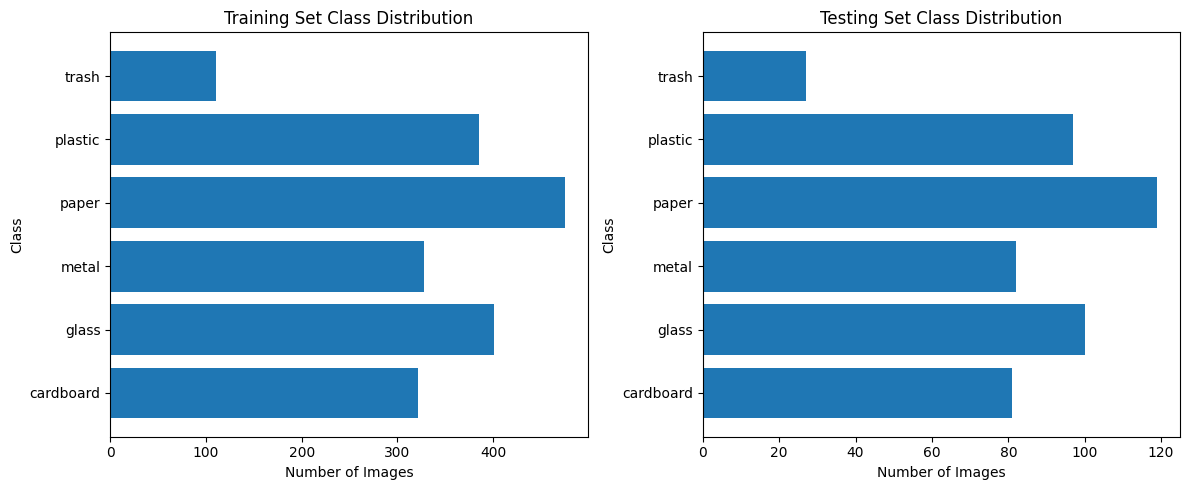

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

# Calculate class distributions
train_counter = Counter([dataset.targets[i] for i in train_idx])
test_counter = Counter([dataset.targets[i] for i in test_idx])

train_labels = list(train_counter.keys())
train_values = list(train_counter.values())

test_labels = list(test_counter.keys())
test_values = list(test_counter.values())

# Plot the distributions with horizontal bars
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
ax[0].barh(train_labels, train_values, tick_label=[classes[i] for i in train_labels])
ax[0].set_title("Training Set Class Distribution")
ax[0].set_ylabel("Class")
ax[0].set_xlabel("Number of Images")

# Testing set distribution
ax[1].barh(test_labels, test_values, tick_label=[classes[i] for i in test_labels])
ax[1].set_title("Testing Set Class Distribution")
ax[1].set_ylabel("Class")
ax[1].set_xlabel("Number of Images")

plt.tight_layout()
plt.show()


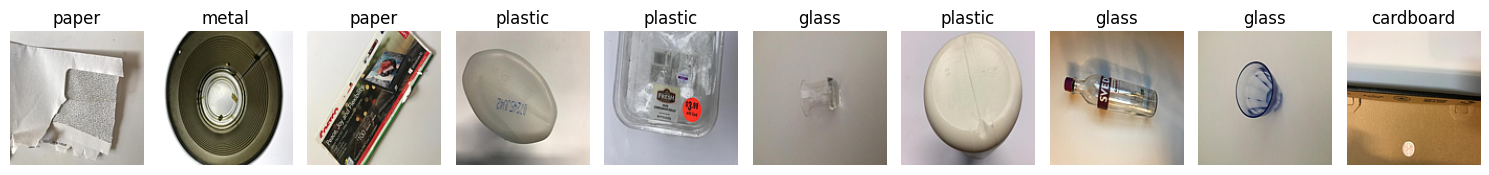

In [7]:
# Function to display images with labels
def imshow_with_labels(images, labels, classes):
    images = images / 2 + 0.5  # Unnormalize
    npimg = images.numpy()
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(npimg[i], (1, 2, 0)))
        ax.set_title(classes[labels[i].item()])  # Convert tensor to index and map to English
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display the first n images with labels
n = 10  # Display fewer images for readability
imshow_with_labels(images[:n], labels[:n], classes)


# Model

In [8]:
from torchvision.models import resnet18, mobilenet_v2, efficientnet_b0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 6

# Define ResNet-18
resnet18_model = resnet18(pretrained=True)
for param in resnet18_model.parameters():
    param.requires_grad = False  # Freeze all layers
# Unfreeze the last two residual blocks (layer3 and layer4)
for param in resnet18_model.layer3.parameters():
    param.requires_grad = True
for param in resnet18_model.layer4.parameters():
    param.requires_grad = True
# Modify the fully connected (FC) layer for 6 classes
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, num_classes)
resnet18_model.fc.requires_grad = True  # Ensure the final layer is trainable
resnet18_model = resnet18_model.to(device)

# # Define MobileNet_v2
# mobilenet_v2_model = mobilenet_v2(pretrained=True)
# for param in mobilenet_v2_model.features.parameters():
#     param.requires_grad = False  # Freeze all layers in the features section
# # Unfreeze the last two inverted residual blocks
# for param in mobilenet_v2_model.features[-12:].parameters():  # Adjusted for two blocks
#     param.requires_grad = True
# # Modify the classifier for 6 classes
# mobilenet_v2_model.classifier[1] = nn.Linear(mobilenet_v2_model.last_channel, num_classes)
# mobilenet_v2_model.classifier[1].requires_grad = True
# mobilenet_v2_model = mobilenet_v2_model.to(device)

# # Define EfficientNet_B0
# efficientnet_b0_model = efficientnet_b0(pretrained=True)
# for param in efficientnet_b0_model.parameters():
#     param.requires_grad = False  # Freeze all layers
# # Unfreeze the last two convolutional blocks
# for param in efficientnet_b0_model.features[-2:].parameters():
#     param.requires_grad = True
# # Modify the classifier for 6 classes
# efficientnet_b0_model.classifier[1] = nn.Linear(efficientnet_b0_model.classifier[1].in_features, num_classes)
# efficientnet_b0_model.classifier[1].requires_grad = True
# efficientnet_b0_model = efficientnet_b0_model.to(device)

# Print a summary of one model (optional)
print(resnet18_model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Before training

ResNet-18 Metrics:
Accuracy: 15.02%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.24      0.11      0.15        81
       glass       0.13      0.12      0.12       100
       metal       0.14      0.48      0.21        82
       paper       0.00      0.00      0.00       119
     plastic       0.25      0.13      0.17        97
       trash       0.08      0.11      0.09        27

    accuracy                           0.15       506
   macro avg       0.14      0.16      0.13       506
weighted avg       0.14      0.15      0.12       506



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


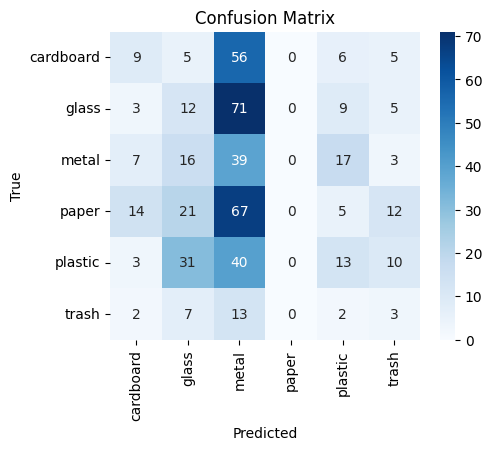

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to calculate detailed metrics
def evaluate_model(model, data_loader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    print(f"Accuracy: {accuracy:.2f}%")

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=classes, digits=2)
    print("Classification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, report, cm

# Evaluate ResNet-18
print("ResNet-18 Metrics:")
resnet18_accuracy_before, resnet18_report_before, resnet18_cm_before = evaluate_model(resnet18_model, test_loader, device, classes)

# # Evaluate MobileNet_v2
# print("\nMobileNet_v2 Metrics:")
# mobilenet_v2_accuracy_before, mobilenet_v2_report_before, mobilenet_v2_cm_before = evaluate_model(mobilenet_v2_model, test_loader, device, classes)

# # Evaluate EfficientNet_B0
# print("\nEfficientNet_B0 Metrics:")
# efficientnet_b0_accuracy_before, efficientnet_b0_report_before, efficientnet_b0_cm_before = evaluate_model(efficientnet_b0_model, test_loader, device, classes)


# Training

In [12]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


In [13]:
import torch.optim as optim
from torch.utils.data import random_split
from collections import Counter
import random
from torchvision.transforms import functional as TF
import optuna

# ================== Define the Training Function ==================
def train_model(model, train_loader, val_loader=None, criterion=None, optimizer=None, device=None, epochs=20, patience=5):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf') if val_loader else None
    patience_counter = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss = val_loss / len(val_loader)
            val_losses.append(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

    return train_losses, val_losses if val_loader else train_losses

# ================== Split the Training Data ==================
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_idx, val_idx = random_split(range(len(train_set)), [train_size, val_size])

# Create subsets for training and validation
train_subset = torch.utils.data.Subset(train_set, train_idx)
val_subset = torch.utils.data.Subset(train_set, val_idx)

# ================== Class Balancing for Training Subset ==================
augmented_images = []
augmented_labels = []

# Count images per class
class_counts = Counter([train_set.dataset.targets[i] for i in train_idx])
max_class_count = max(class_counts.values())

# Augment underrepresented classes
for class_idx, count in class_counts.items():
    if count < max_class_count:
        diff = max_class_count - count
        print(f"Augmenting class {classes[class_idx]}: {count} -> {max_class_count}")

        # Get all images and their correct labels for this class
        class_images = [train_set.dataset[i] for i in train_idx if train_set.dataset.targets[i] == class_idx]

        # Apply augmentations
        for _ in range(diff):
            img, label = random.choice(class_images)  # Preserve correct label
            augmented_img = TF.rotate(img, angle=random.uniform(-15, 15))
            augmented_img = TF.hflip(augmented_img) if random.random() > 0.5 else augmented_img
            augmented_images.append(augmented_img)
            augmented_labels.append(label)

# Combine original and augmented data for the training subset
train_dataset = [(train_set.dataset[i][0], train_set.dataset.targets[i]) for i in train_idx]
train_dataset.extend(zip(augmented_images, augmented_labels))

# ********** OPTUNA INTEGRATED **********

# ================== Create DataLoaders (Dynamic) ==================
def get_data_loaders(batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# ================== Define Optuna Objective ==================
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Get DataLoaders with the suggested batch size
    train_loader, val_loader = get_data_loaders(batch_size)

    # Define the model
    model = resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.layer3.parameters():
        param.requires_grad = True
    for param in model.layer4.parameters():
        param.requires_grad = True
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    # Define optimizer and criterion
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, epochs=20, patience=5
    )

    # Return the best validation loss
    return min(val_losses)

# ================== Run Optuna Study ==================
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# ================== Best Hyperparameters ==================
print("Best Hyperparameters:", study.best_params)

# # ================== Train ResNet-18 ==================
# print("Training ResNet-18...")
# resnet18_optimizer = optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9)
# resnet18_train_losses, resnet18_val_losses = train_model(
#     resnet18_model, train_loader, val_loader, criterion, resnet18_optimizer, device
# )

# # ================== Train MobileNet_v2 ==================
# print("\nTraining MobileNet_v2...")
# mobilenet_v2_optimizer = optim.SGD(mobilenet_v2_model.parameters(), lr=0.001, momentum=0.9)
# mobilenet_v2_train_losses, mobilenet_v2_val_losses = train_model(
#     mobilenet_v2_model, train_loader, val_loader, criterion, mobilenet_v2_optimizer, device
# )

# # ================== Train EfficientNet_B0 ==================
# print("\nTraining EfficientNet_B0...")
# efficientnet_b0_optimizer = optim.SGD(efficientnet_b0_model.parameters(), lr=0.001, momentum=0.9)
# efficientnet_b0_train_losses, efficientnet_b0_val_losses = train_model(
#     efficientnet_b0_model, train_loader, val_loader, criterion, efficientnet_b0_optimizer, device
# )


Augmenting class glass: 408 -> 474
Augmenting class metal: 319 -> 474
Augmenting class plastic: 96 -> 474
Augmenting class cardboard: 319 -> 474


[I 2024-12-16 08:19:08,559] A new study created in memory with name: no-name-df7e84f3-41b6-4498-b213-72fe30512d52
<ipython-input-13-6427ba5b7e4b>:113: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
<ipython-input-13-6427ba5b7e4b>:114: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Argum

Epoch 1/20, Train Loss: 1.7591, Val Loss: 1.5962
Epoch 2/20, Train Loss: 1.2649, Val Loss: 1.3978
Epoch 3/20, Train Loss: 1.0182, Val Loss: 1.2709
Epoch 4/20, Train Loss: 0.8513, Val Loss: 1.1755
Epoch 5/20, Train Loss: 0.7319, Val Loss: 1.1090
Epoch 6/20, Train Loss: 0.6524, Val Loss: 1.0601
Epoch 7/20, Train Loss: 0.5751, Val Loss: 1.0192
Epoch 8/20, Train Loss: 0.5180, Val Loss: 0.9865
Epoch 9/20, Train Loss: 0.4762, Val Loss: 0.9573
Epoch 10/20, Train Loss: 0.4280, Val Loss: 0.9412
Epoch 11/20, Train Loss: 0.3971, Val Loss: 0.9200
Epoch 12/20, Train Loss: 0.3639, Val Loss: 0.9132
Epoch 13/20, Train Loss: 0.3332, Val Loss: 0.8988
Epoch 14/20, Train Loss: 0.3116, Val Loss: 0.8889
Epoch 15/20, Train Loss: 0.2862, Val Loss: 0.8805
Epoch 16/20, Train Loss: 0.2670, Val Loss: 0.8719
Epoch 17/20, Train Loss: 0.2474, Val Loss: 0.8705
Epoch 18/20, Train Loss: 0.2299, Val Loss: 0.8597
Epoch 19/20, Train Loss: 0.2223, Val Loss: 0.8620


[I 2024-12-16 08:20:13,348] Trial 0 finished with value: 0.8462924212217331 and parameters: {'lr': 0.0007820580261041562, 'momentum': 0.6985992878132148, 'batch_size': 128}. Best is trial 0 with value: 0.8462924212217331.


Epoch 20/20, Train Loss: 0.2030, Val Loss: 0.8463
Epoch 1/20, Train Loss: 5.6287, Val Loss: 37.2153
Epoch 2/20, Train Loss: 2.5651, Val Loss: 1.6667
Epoch 3/20, Train Loss: 1.0749, Val Loss: 1.7629
Epoch 4/20, Train Loss: 1.0178, Val Loss: 1.3627
Epoch 5/20, Train Loss: 0.7371, Val Loss: 1.3868
Epoch 6/20, Train Loss: 0.5918, Val Loss: 1.4050
Epoch 7/20, Train Loss: 0.7933, Val Loss: 1.1186
Epoch 8/20, Train Loss: 0.5896, Val Loss: 1.1036
Epoch 9/20, Train Loss: 0.4330, Val Loss: 1.2687
Epoch 10/20, Train Loss: 0.5195, Val Loss: 1.2380
Epoch 11/20, Train Loss: 0.3949, Val Loss: 1.3819
Epoch 12/20, Train Loss: 0.3811, Val Loss: 1.2125


[I 2024-12-16 08:21:01,587] Trial 1 finished with value: 1.103642688347743 and parameters: {'lr': 0.06407819144815759, 'momentum': 0.9192585651218906, 'batch_size': 32}. Best is trial 0 with value: 0.8462924212217331.


Early stopping at epoch 13
Epoch 1/20, Train Loss: 0.8143, Val Loss: 0.9568
Epoch 2/20, Train Loss: 0.2228, Val Loss: 0.9000
Epoch 3/20, Train Loss: 0.0931, Val Loss: 0.9856
Epoch 4/20, Train Loss: 0.0641, Val Loss: 0.9189
Epoch 5/20, Train Loss: 0.0517, Val Loss: 1.0028
Epoch 6/20, Train Loss: 0.0311, Val Loss: 0.9659


[I 2024-12-16 08:21:27,270] Trial 2 finished with value: 0.8999997400320493 and parameters: {'lr': 0.0019382636239128215, 'momentum': 0.8593206530652044, 'batch_size': 32}. Best is trial 0 with value: 0.8462924212217331.


Early stopping at epoch 7
Epoch 1/20, Train Loss: 0.9956, Val Loss: 1.1733
Epoch 2/20, Train Loss: 0.4180, Val Loss: 0.8430
Epoch 3/20, Train Loss: 0.2485, Val Loss: 0.8723
Epoch 4/20, Train Loss: 0.1493, Val Loss: 0.8744
Epoch 5/20, Train Loss: 0.1210, Val Loss: 0.9982
Epoch 6/20, Train Loss: 0.0877, Val Loss: 0.8382
Epoch 7/20, Train Loss: 0.0999, Val Loss: 0.8739
Epoch 8/20, Train Loss: 0.1055, Val Loss: 0.9720
Epoch 9/20, Train Loss: 0.0533, Val Loss: 0.8595
Epoch 10/20, Train Loss: 0.0384, Val Loss: 0.9116


[I 2024-12-16 08:22:05,145] Trial 3 finished with value: 0.8382447234221867 and parameters: {'lr': 0.005537301660235928, 'momentum': 0.5555090556415474, 'batch_size': 64}. Best is trial 3 with value: 0.8382447234221867.


Early stopping at epoch 11
Epoch 1/20, Train Loss: 0.5792, Val Loss: 0.9216
Epoch 2/20, Train Loss: 0.0582, Val Loss: 1.0150
Epoch 3/20, Train Loss: 0.0158, Val Loss: 1.0964
Epoch 4/20, Train Loss: 0.0078, Val Loss: 1.0498
Epoch 5/20, Train Loss: 0.0067, Val Loss: 1.1321


[I 2024-12-16 08:22:24,684] Trial 4 finished with value: 0.9216315746307373 and parameters: {'lr': 0.05573945373271885, 'momentum': 0.6446177641974453, 'batch_size': 128}. Best is trial 3 with value: 0.8382447234221867.


Early stopping at epoch 6
Epoch 1/20, Train Loss: 0.8424, Val Loss: 1.5608
Epoch 2/20, Train Loss: 0.1480, Val Loss: 2.1192
Epoch 3/20, Train Loss: 0.0449, Val Loss: 2.0628
Epoch 4/20, Train Loss: 0.0229, Val Loss: 2.1462
Epoch 5/20, Train Loss: 0.0182, Val Loss: 2.2084


[I 2024-12-16 08:22:44,303] Trial 5 finished with value: 1.5607914626598358 and parameters: {'lr': 0.009363925149473488, 'momentum': 0.9528484377247448, 'batch_size': 128}. Best is trial 3 with value: 0.8382447234221867.


Early stopping at epoch 6
Epoch 1/20, Train Loss: 0.8866, Val Loss: 3.3941
Epoch 2/20, Train Loss: 1.0960, Val Loss: 2.3896
Epoch 3/20, Train Loss: 0.7567, Val Loss: 2.0305
Epoch 4/20, Train Loss: 0.4456, Val Loss: 1.8004
Epoch 5/20, Train Loss: 0.5176, Val Loss: 1.7576
Epoch 6/20, Train Loss: 0.3659, Val Loss: 1.7674
Epoch 7/20, Train Loss: 0.2805, Val Loss: 1.5711
Epoch 8/20, Train Loss: 0.3545, Val Loss: 2.0443
Epoch 9/20, Train Loss: 0.4674, Val Loss: 1.9631
Epoch 10/20, Train Loss: 0.5152, Val Loss: 1.9698
Epoch 11/20, Train Loss: 0.6284, Val Loss: 1.4030
Epoch 12/20, Train Loss: 1.0132, Val Loss: 2.6621
Epoch 13/20, Train Loss: 0.2850, Val Loss: 1.4757
Epoch 14/20, Train Loss: 0.2183, Val Loss: 1.1771
Epoch 15/20, Train Loss: 0.3610, Val Loss: 2.0260
Epoch 16/20, Train Loss: 0.3579, Val Loss: 1.7487
Epoch 17/20, Train Loss: 0.3304, Val Loss: 1.0853
Epoch 18/20, Train Loss: 0.5063, Val Loss: 2.3548
Epoch 19/20, Train Loss: 0.1656, Val Loss: 1.4372


[I 2024-12-16 08:23:56,909] Trial 6 finished with value: 1.0853066329772656 and parameters: {'lr': 0.0065941387752662855, 'momentum': 0.9532860219004138, 'batch_size': 32}. Best is trial 3 with value: 0.8382447234221867.


Epoch 20/20, Train Loss: 0.2911, Val Loss: 2.1726
Epoch 1/20, Train Loss: 0.6007, Val Loss: 3.3201
Epoch 2/20, Train Loss: 0.3637, Val Loss: 4.4648
Epoch 3/20, Train Loss: 0.2155, Val Loss: 1.4357
Epoch 4/20, Train Loss: 0.0592, Val Loss: 1.3673
Epoch 5/20, Train Loss: 0.0581, Val Loss: 3.3208
Epoch 6/20, Train Loss: 0.2296, Val Loss: 2.1792
Epoch 7/20, Train Loss: 0.1772, Val Loss: 1.3582
Epoch 8/20, Train Loss: 0.0435, Val Loss: 1.2910
Epoch 9/20, Train Loss: 0.0308, Val Loss: 1.3200
Epoch 10/20, Train Loss: 0.0232, Val Loss: 1.8217
Epoch 11/20, Train Loss: 0.0810, Val Loss: 1.3245
Epoch 12/20, Train Loss: 0.0294, Val Loss: 1.2110
Epoch 13/20, Train Loss: 0.0289, Val Loss: 1.1528
Epoch 14/20, Train Loss: 0.0637, Val Loss: 2.0550
Epoch 15/20, Train Loss: 0.2254, Val Loss: 1.4191
Epoch 16/20, Train Loss: 0.1797, Val Loss: 3.8287
Epoch 17/20, Train Loss: 0.2522, Val Loss: 1.1855


[I 2024-12-16 08:25:02,195] Trial 7 finished with value: 1.1528449471180255 and parameters: {'lr': 0.029730819705243258, 'momentum': 0.5469924664980682, 'batch_size': 32}. Best is trial 3 with value: 0.8382447234221867.


Early stopping at epoch 18
Epoch 1/20, Train Loss: 0.7736, Val Loss: 1.2853
Epoch 2/20, Train Loss: 0.2306, Val Loss: 1.3481
Epoch 3/20, Train Loss: 0.1773, Val Loss: 1.3581
Epoch 4/20, Train Loss: 0.1899, Val Loss: 1.7221
Epoch 5/20, Train Loss: 0.1710, Val Loss: 1.9304


[I 2024-12-16 08:25:22,597] Trial 8 finished with value: 1.2853044356618608 and parameters: {'lr': 0.003712662262190588, 'momentum': 0.9392317197136708, 'batch_size': 64}. Best is trial 3 with value: 0.8382447234221867.


Early stopping at epoch 6
Epoch 1/20, Train Loss: 0.7541, Val Loss: 1.3093
Epoch 2/20, Train Loss: 0.1095, Val Loss: 1.3190
Epoch 3/20, Train Loss: 0.0332, Val Loss: 1.2904
Epoch 4/20, Train Loss: 0.0148, Val Loss: 1.3392
Epoch 5/20, Train Loss: 0.0106, Val Loss: 1.3498
Epoch 6/20, Train Loss: 0.0083, Val Loss: 1.3401
Epoch 7/20, Train Loss: 0.0076, Val Loss: 1.3433


[I 2024-12-16 08:25:48,905] Trial 9 finished with value: 1.2903507351875305 and parameters: {'lr': 0.015144046307166611, 'momentum': 0.8032621045487218, 'batch_size': 128}. Best is trial 3 with value: 0.8382447234221867.


Early stopping at epoch 8
Epoch 1/20, Train Loss: 1.9247, Val Loss: 1.7934
Epoch 2/20, Train Loss: 1.6421, Val Loss: 1.6612
Epoch 3/20, Train Loss: 1.5091, Val Loss: 1.5718
Epoch 4/20, Train Loss: 1.4026, Val Loss: 1.5044
Epoch 5/20, Train Loss: 1.3184, Val Loss: 1.4524
Epoch 6/20, Train Loss: 1.2560, Val Loss: 1.4084
Epoch 7/20, Train Loss: 1.2025, Val Loss: 1.3747
Epoch 8/20, Train Loss: 1.1435, Val Loss: 1.3478
Epoch 9/20, Train Loss: 1.0832, Val Loss: 1.2939
Epoch 10/20, Train Loss: 1.0473, Val Loss: 1.2831
Epoch 11/20, Train Loss: 0.9943, Val Loss: 1.2425
Epoch 12/20, Train Loss: 0.9670, Val Loss: 1.2271
Epoch 13/20, Train Loss: 0.9215, Val Loss: 1.1906
Epoch 14/20, Train Loss: 0.8855, Val Loss: 1.1792
Epoch 15/20, Train Loss: 0.8776, Val Loss: 1.1613
Epoch 16/20, Train Loss: 0.8584, Val Loss: 1.1523
Epoch 17/20, Train Loss: 0.8189, Val Loss: 1.1335
Epoch 18/20, Train Loss: 0.7935, Val Loss: 1.1245
Epoch 19/20, Train Loss: 0.7883, Val Loss: 1.1128


[I 2024-12-16 08:26:56,393] Trial 10 finished with value: 1.0927310500826155 and parameters: {'lr': 0.00014182313907004404, 'momentum': 0.5165851802626886, 'batch_size': 64}. Best is trial 3 with value: 0.8382447234221867.


Epoch 20/20, Train Loss: 0.7463, Val Loss: 1.0927
Epoch 1/20, Train Loss: 1.4668, Val Loss: 1.3803
Epoch 2/20, Train Loss: 0.9818, Val Loss: 1.2058
Epoch 3/20, Train Loss: 0.7639, Val Loss: 1.0644
Epoch 4/20, Train Loss: 0.6329, Val Loss: 0.9869
Epoch 5/20, Train Loss: 0.5145, Val Loss: 0.9295
Epoch 6/20, Train Loss: 0.4443, Val Loss: 0.8930
Epoch 7/20, Train Loss: 0.3903, Val Loss: 0.8686
Epoch 8/20, Train Loss: 0.3427, Val Loss: 0.8658
Epoch 9/20, Train Loss: 0.3011, Val Loss: 0.8599
Epoch 10/20, Train Loss: 0.2624, Val Loss: 0.8360
Epoch 11/20, Train Loss: 0.2635, Val Loss: 0.8340
Epoch 12/20, Train Loss: 0.2144, Val Loss: 0.8492
Epoch 13/20, Train Loss: 0.1996, Val Loss: 0.8256
Epoch 14/20, Train Loss: 0.1780, Val Loss: 0.8505
Epoch 15/20, Train Loss: 0.1642, Val Loss: 0.8318
Epoch 16/20, Train Loss: 0.1770, Val Loss: 0.8150
Epoch 17/20, Train Loss: 0.1461, Val Loss: 0.8166
Epoch 18/20, Train Loss: 0.1391, Val Loss: 0.8335
Epoch 19/20, Train Loss: 0.1100, Val Loss: 0.8301


[I 2024-12-16 08:28:04,194] Trial 11 finished with value: 0.8150100920881543 and parameters: {'lr': 0.0008147152159095032, 'momentum': 0.6717970054269127, 'batch_size': 64}. Best is trial 11 with value: 0.8150100920881543.


Epoch 20/20, Train Loss: 0.1458, Val Loss: 0.8586
Epoch 1/20, Train Loss: 1.5673, Val Loss: 1.4895
Epoch 2/20, Train Loss: 1.0785, Val Loss: 1.2846
Epoch 3/20, Train Loss: 0.8456, Val Loss: 1.1494
Epoch 4/20, Train Loss: 0.6956, Val Loss: 1.0867
Epoch 5/20, Train Loss: 0.5968, Val Loss: 1.0328
Epoch 6/20, Train Loss: 0.5234, Val Loss: 0.9700
Epoch 7/20, Train Loss: 0.4776, Val Loss: 0.9441
Epoch 8/20, Train Loss: 0.4007, Val Loss: 0.9464
Epoch 9/20, Train Loss: 0.3569, Val Loss: 0.9333
Epoch 10/20, Train Loss: 0.3634, Val Loss: 0.9011
Epoch 11/20, Train Loss: 0.3374, Val Loss: 0.8893
Epoch 12/20, Train Loss: 0.3426, Val Loss: 0.8732
Epoch 13/20, Train Loss: 0.2555, Val Loss: 0.8708
Epoch 14/20, Train Loss: 0.2337, Val Loss: 0.8944
Epoch 15/20, Train Loss: 0.2523, Val Loss: 0.8671
Epoch 16/20, Train Loss: 0.2091, Val Loss: 0.8782
Epoch 17/20, Train Loss: 0.1818, Val Loss: 0.8939
Epoch 18/20, Train Loss: 0.1659, Val Loss: 0.8664
Epoch 19/20, Train Loss: 0.1476, Val Loss: 0.8826


[I 2024-12-16 08:29:12,258] Trial 12 finished with value: 0.8533121432576861 and parameters: {'lr': 0.0007609755456125727, 'momentum': 0.6168951193900472, 'batch_size': 64}. Best is trial 11 with value: 0.8150100920881543.


Epoch 20/20, Train Loss: 0.1931, Val Loss: 0.8533
Epoch 1/20, Train Loss: 1.8454, Val Loss: 1.7637
Epoch 2/20, Train Loss: 1.5620, Val Loss: 1.6413
Epoch 3/20, Train Loss: 1.4035, Val Loss: 1.5387
Epoch 4/20, Train Loss: 1.2609, Val Loss: 1.4629
Epoch 5/20, Train Loss: 1.1603, Val Loss: 1.3889
Epoch 6/20, Train Loss: 1.0787, Val Loss: 1.3173
Epoch 7/20, Train Loss: 1.0070, Val Loss: 1.2663
Epoch 8/20, Train Loss: 0.9469, Val Loss: 1.2453
Epoch 9/20, Train Loss: 0.9064, Val Loss: 1.2197
Epoch 10/20, Train Loss: 0.8494, Val Loss: 1.1879
Epoch 11/20, Train Loss: 0.7907, Val Loss: 1.1379
Epoch 12/20, Train Loss: 0.7632, Val Loss: 1.1207
Epoch 13/20, Train Loss: 0.7084, Val Loss: 1.0931
Epoch 14/20, Train Loss: 0.6829, Val Loss: 1.0889
Epoch 15/20, Train Loss: 0.6611, Val Loss: 1.0790
Epoch 16/20, Train Loss: 0.6486, Val Loss: 1.0752
Epoch 17/20, Train Loss: 0.5964, Val Loss: 1.0513
Epoch 18/20, Train Loss: 0.5665, Val Loss: 1.0222
Epoch 19/20, Train Loss: 0.5700, Val Loss: 1.0074


[I 2024-12-16 08:30:20,455] Trial 13 finished with value: 1.0074143239430018 and parameters: {'lr': 0.00020703357320507623, 'momentum': 0.6076496572893872, 'batch_size': 64}. Best is trial 11 with value: 0.8150100920881543.


Epoch 20/20, Train Loss: 0.5399, Val Loss: 1.0099
Epoch 1/20, Train Loss: 1.4358, Val Loss: 1.3439
Epoch 2/20, Train Loss: 0.8242, Val Loss: 1.1005
Epoch 3/20, Train Loss: 0.6027, Val Loss: 1.0397
Epoch 4/20, Train Loss: 0.4652, Val Loss: 0.9894
Epoch 5/20, Train Loss: 0.4020, Val Loss: 0.8820
Epoch 6/20, Train Loss: 0.3647, Val Loss: 0.8736
Epoch 7/20, Train Loss: 0.2924, Val Loss: 0.8927
Epoch 8/20, Train Loss: 0.2226, Val Loss: 0.8345
Epoch 9/20, Train Loss: 0.1907, Val Loss: 0.8492
Epoch 10/20, Train Loss: 0.2105, Val Loss: 0.8629
Epoch 11/20, Train Loss: 0.2053, Val Loss: 0.8602
Epoch 12/20, Train Loss: 0.1401, Val Loss: 0.8735


[I 2024-12-16 08:31:04,693] Trial 14 finished with value: 0.8344773054122925 and parameters: {'lr': 0.0011523121867934288, 'momentum': 0.7018762660239859, 'batch_size': 64}. Best is trial 11 with value: 0.8150100920881543.


Early stopping at epoch 13
Epoch 1/20, Train Loss: 1.6081, Val Loss: 1.4545
Epoch 2/20, Train Loss: 1.0855, Val Loss: 1.2392
Epoch 3/20, Train Loss: 0.8367, Val Loss: 1.1222
Epoch 4/20, Train Loss: 0.6885, Val Loss: 1.0465
Epoch 5/20, Train Loss: 0.5642, Val Loss: 1.0056
Epoch 6/20, Train Loss: 0.4909, Val Loss: 0.9679
Epoch 7/20, Train Loss: 0.4536, Val Loss: 0.9151
Epoch 8/20, Train Loss: 0.4082, Val Loss: 0.9103
Epoch 9/20, Train Loss: 0.3146, Val Loss: 0.9174
Epoch 10/20, Train Loss: 0.3090, Val Loss: 0.9146
Epoch 11/20, Train Loss: 0.3076, Val Loss: 0.8941
Epoch 12/20, Train Loss: 0.2619, Val Loss: 0.8704
Epoch 13/20, Train Loss: 0.2373, Val Loss: 0.8771
Epoch 14/20, Train Loss: 0.1985, Val Loss: 0.8747
Epoch 15/20, Train Loss: 0.2005, Val Loss: 0.8671
Epoch 16/20, Train Loss: 0.1822, Val Loss: 0.8510
Epoch 17/20, Train Loss: 0.1671, Val Loss: 0.8562
Epoch 18/20, Train Loss: 0.1405, Val Loss: 0.8627
Epoch 19/20, Train Loss: 0.1757, Val Loss: 0.8720


[I 2024-12-16 08:32:13,119] Trial 15 finished with value: 0.8131090147154671 and parameters: {'lr': 0.0005692249758989072, 'momentum': 0.7383249131449185, 'batch_size': 64}. Best is trial 15 with value: 0.8131090147154671.


Epoch 20/20, Train Loss: 0.1565, Val Loss: 0.8131
Epoch 1/20, Train Loss: 1.6718, Val Loss: 1.5791
Epoch 2/20, Train Loss: 1.2054, Val Loss: 1.3714
Epoch 3/20, Train Loss: 0.9833, Val Loss: 1.2280
Epoch 4/20, Train Loss: 0.8372, Val Loss: 1.1333
Epoch 5/20, Train Loss: 0.7121, Val Loss: 1.0926
Epoch 6/20, Train Loss: 0.6240, Val Loss: 1.0562
Epoch 7/20, Train Loss: 0.5887, Val Loss: 1.0088
Epoch 8/20, Train Loss: 0.5012, Val Loss: 0.9912
Epoch 9/20, Train Loss: 0.4555, Val Loss: 0.9402
Epoch 10/20, Train Loss: 0.4308, Val Loss: 0.9545
Epoch 11/20, Train Loss: 0.4256, Val Loss: 0.9214
Epoch 12/20, Train Loss: 0.3518, Val Loss: 0.9170
Epoch 13/20, Train Loss: 0.3425, Val Loss: 0.9209
Epoch 14/20, Train Loss: 0.3430, Val Loss: 0.9185
Epoch 15/20, Train Loss: 0.2788, Val Loss: 0.8702
Epoch 16/20, Train Loss: 0.2674, Val Loss: 0.8851
Epoch 17/20, Train Loss: 0.2446, Val Loss: 0.8960
Epoch 18/20, Train Loss: 0.2198, Val Loss: 0.9039
Epoch 19/20, Train Loss: 0.2691, Val Loss: 0.8699


[I 2024-12-16 08:33:21,109] Trial 16 finished with value: 0.865136810711452 and parameters: {'lr': 0.0003302119767543404, 'momentum': 0.7772474517617558, 'batch_size': 64}. Best is trial 15 with value: 0.8131090147154671.


Epoch 20/20, Train Loss: 0.1995, Val Loss: 0.8651
Epoch 1/20, Train Loss: 1.6741, Val Loss: 1.6420
Epoch 2/20, Train Loss: 1.2555, Val Loss: 1.3843
Epoch 3/20, Train Loss: 0.9969, Val Loss: 1.2487
Epoch 4/20, Train Loss: 0.8318, Val Loss: 1.1706
Epoch 5/20, Train Loss: 0.7579, Val Loss: 1.1098
Epoch 6/20, Train Loss: 0.6398, Val Loss: 1.0508
Epoch 7/20, Train Loss: 0.5647, Val Loss: 1.0365
Epoch 8/20, Train Loss: 0.5383, Val Loss: 0.9748
Epoch 9/20, Train Loss: 0.4709, Val Loss: 0.9584
Epoch 10/20, Train Loss: 0.4586, Val Loss: 0.9740
Epoch 11/20, Train Loss: 0.3837, Val Loss: 0.9311
Epoch 12/20, Train Loss: 0.4011, Val Loss: 0.9447
Epoch 13/20, Train Loss: 0.3777, Val Loss: 0.9052
Epoch 14/20, Train Loss: 0.3115, Val Loss: 0.9027
Epoch 15/20, Train Loss: 0.2975, Val Loss: 0.8981
Epoch 16/20, Train Loss: 0.2777, Val Loss: 0.8867
Epoch 17/20, Train Loss: 0.2589, Val Loss: 0.9071
Epoch 18/20, Train Loss: 0.2405, Val Loss: 0.8785
Epoch 19/20, Train Loss: 0.2696, Val Loss: 0.8878


[I 2024-12-16 08:34:28,684] Trial 17 finished with value: 0.8609253168106079 and parameters: {'lr': 0.0003829921326262754, 'momentum': 0.7306841554783972, 'batch_size': 64}. Best is trial 15 with value: 0.8131090147154671.


Epoch 20/20, Train Loss: 0.2140, Val Loss: 0.8609
Epoch 1/20, Train Loss: 1.0578, Val Loss: 1.0551
Epoch 2/20, Train Loss: 0.4047, Val Loss: 0.9309
Epoch 3/20, Train Loss: 0.2532, Val Loss: 0.9013
Epoch 4/20, Train Loss: 0.2077, Val Loss: 0.9130
Epoch 5/20, Train Loss: 0.1511, Val Loss: 0.8239
Epoch 6/20, Train Loss: 0.1468, Val Loss: 0.8493
Epoch 7/20, Train Loss: 0.0963, Val Loss: 0.9091
Epoch 8/20, Train Loss: 0.0628, Val Loss: 0.9354
Epoch 9/20, Train Loss: 0.0956, Val Loss: 0.9688


[I 2024-12-16 08:35:02,798] Trial 18 finished with value: 0.8239279772554126 and parameters: {'lr': 0.0022876219380207827, 'momentum': 0.8186500121460605, 'batch_size': 64}. Best is trial 15 with value: 0.8131090147154671.


Early stopping at epoch 10
Epoch 1/20, Train Loss: 1.9121, Val Loss: 1.7855
Epoch 2/20, Train Loss: 1.6501, Val Loss: 1.6746
Epoch 3/20, Train Loss: 1.5290, Val Loss: 1.6119
Epoch 4/20, Train Loss: 1.4259, Val Loss: 1.5556
Epoch 5/20, Train Loss: 1.3454, Val Loss: 1.5115
Epoch 6/20, Train Loss: 1.2850, Val Loss: 1.4519
Epoch 7/20, Train Loss: 1.2248, Val Loss: 1.4126
Epoch 8/20, Train Loss: 1.1600, Val Loss: 1.3781
Epoch 9/20, Train Loss: 1.1003, Val Loss: 1.3531
Epoch 10/20, Train Loss: 1.0680, Val Loss: 1.3271
Epoch 11/20, Train Loss: 1.0101, Val Loss: 1.2796
Epoch 12/20, Train Loss: 0.9648, Val Loss: 1.2587
Epoch 13/20, Train Loss: 0.9349, Val Loss: 1.2561
Epoch 14/20, Train Loss: 0.9084, Val Loss: 1.2272
Epoch 15/20, Train Loss: 0.8821, Val Loss: 1.2079
Epoch 16/20, Train Loss: 0.8458, Val Loss: 1.1855
Epoch 17/20, Train Loss: 0.8167, Val Loss: 1.1802
Epoch 18/20, Train Loss: 0.8157, Val Loss: 1.1731
Epoch 19/20, Train Loss: 0.7892, Val Loss: 1.1383


[I 2024-12-16 08:36:11,251] Trial 19 finished with value: 1.1254883578845434 and parameters: {'lr': 0.0001022057040827013, 'momentum': 0.6535565622102438, 'batch_size': 64}. Best is trial 15 with value: 0.8131090147154671.


Epoch 20/20, Train Loss: 0.7459, Val Loss: 1.1255
Epoch 1/20, Train Loss: 1.4729, Val Loss: 1.3434
Epoch 2/20, Train Loss: 0.8294, Val Loss: 1.1274
Epoch 3/20, Train Loss: 0.5908, Val Loss: 1.0312
Epoch 4/20, Train Loss: 0.4598, Val Loss: 0.9710
Epoch 5/20, Train Loss: 0.4115, Val Loss: 0.9299
Epoch 6/20, Train Loss: 0.3187, Val Loss: 0.9068
Epoch 7/20, Train Loss: 0.3106, Val Loss: 0.9131
Epoch 8/20, Train Loss: 0.2471, Val Loss: 0.8667
Epoch 9/20, Train Loss: 0.1944, Val Loss: 0.9058
Epoch 10/20, Train Loss: 0.2061, Val Loss: 0.8778
Epoch 11/20, Train Loss: 0.1767, Val Loss: 0.8633
Epoch 12/20, Train Loss: 0.1543, Val Loss: 0.8959
Epoch 13/20, Train Loss: 0.1340, Val Loss: 0.8614
Epoch 14/20, Train Loss: 0.1063, Val Loss: 0.8703
Epoch 15/20, Train Loss: 0.1052, Val Loss: 0.8654
Epoch 16/20, Train Loss: 0.0981, Val Loss: 0.8573
Epoch 17/20, Train Loss: 0.0722, Val Loss: 0.9000
Epoch 18/20, Train Loss: 0.1087, Val Loss: 0.8696
Epoch 19/20, Train Loss: 0.0688, Val Loss: 0.9165


[I 2024-12-16 08:37:19,394] Trial 20 finished with value: 0.8573190995625087 and parameters: {'lr': 0.0004906825492507152, 'momentum': 0.8635406202967703, 'batch_size': 64}. Best is trial 15 with value: 0.8131090147154671.


Epoch 20/20, Train Loss: 0.0590, Val Loss: 0.8617
Epoch 1/20, Train Loss: 0.9900, Val Loss: 1.1288
Epoch 2/20, Train Loss: 0.3644, Val Loss: 0.9250
Epoch 3/20, Train Loss: 0.2193, Val Loss: 0.9414
Epoch 4/20, Train Loss: 0.1997, Val Loss: 0.9066
Epoch 5/20, Train Loss: 0.1547, Val Loss: 0.9824
Epoch 6/20, Train Loss: 0.1364, Val Loss: 0.9800
Epoch 7/20, Train Loss: 0.0778, Val Loss: 0.9624
Epoch 8/20, Train Loss: 0.0940, Val Loss: 1.0134


[I 2024-12-16 08:37:50,033] Trial 21 finished with value: 0.906602999993733 and parameters: {'lr': 0.002524200886814739, 'momentum': 0.8183198256584361, 'batch_size': 64}. Best is trial 15 with value: 0.8131090147154671.


Early stopping at epoch 9
Epoch 1/20, Train Loss: 1.2826, Val Loss: 1.1783
Epoch 2/20, Train Loss: 0.6320, Val Loss: 0.9678
Epoch 3/20, Train Loss: 0.4199, Val Loss: 0.8895
Epoch 4/20, Train Loss: 0.3340, Val Loss: 0.8577
Epoch 5/20, Train Loss: 0.2612, Val Loss: 0.8469
Epoch 6/20, Train Loss: 0.1841, Val Loss: 0.8424
Epoch 7/20, Train Loss: 0.1650, Val Loss: 0.8627
Epoch 8/20, Train Loss: 0.1953, Val Loss: 0.8918
Epoch 9/20, Train Loss: 0.1105, Val Loss: 0.8644
Epoch 10/20, Train Loss: 0.0911, Val Loss: 0.8357
Epoch 11/20, Train Loss: 0.1350, Val Loss: 0.8715
Epoch 12/20, Train Loss: 0.0820, Val Loss: 0.9061
Epoch 13/20, Train Loss: 0.0673, Val Loss: 0.8884
Epoch 14/20, Train Loss: 0.0621, Val Loss: 0.8989


[I 2024-12-16 08:38:41,580] Trial 22 finished with value: 0.8357373816626412 and parameters: {'lr': 0.001450774708758203, 'momentum': 0.7586667185639894, 'batch_size': 64}. Best is trial 15 with value: 0.8131090147154671.


Early stopping at epoch 15
Epoch 1/20, Train Loss: 1.4757, Val Loss: 1.3340
Epoch 2/20, Train Loss: 0.9416, Val Loss: 1.1251
Epoch 3/20, Train Loss: 0.7368, Val Loss: 1.0271
Epoch 4/20, Train Loss: 0.5816, Val Loss: 0.9653
Epoch 5/20, Train Loss: 0.4686, Val Loss: 0.9206
Epoch 6/20, Train Loss: 0.4259, Val Loss: 0.9405
Epoch 7/20, Train Loss: 0.3527, Val Loss: 0.8980
Epoch 8/20, Train Loss: 0.3221, Val Loss: 0.8679
Epoch 9/20, Train Loss: 0.2623, Val Loss: 0.8692
Epoch 10/20, Train Loss: 0.2333, Val Loss: 0.8781
Epoch 11/20, Train Loss: 0.2265, Val Loss: 0.8588
Epoch 12/20, Train Loss: 0.2070, Val Loss: 0.8635
Epoch 13/20, Train Loss: 0.1609, Val Loss: 0.8654
Epoch 14/20, Train Loss: 0.1646, Val Loss: 0.8506
Epoch 15/20, Train Loss: 0.1793, Val Loss: 0.8384
Epoch 16/20, Train Loss: 0.1769, Val Loss: 0.8671
Epoch 17/20, Train Loss: 0.1171, Val Loss: 0.8310
Epoch 18/20, Train Loss: 0.1166, Val Loss: 0.8661
Epoch 19/20, Train Loss: 0.1623, Val Loss: 0.8684


[I 2024-12-16 08:39:49,524] Trial 23 finished with value: 0.8309876152447292 and parameters: {'lr': 0.0008123301238472216, 'momentum': 0.7116845762443225, 'batch_size': 64}. Best is trial 15 with value: 0.8131090147154671.


Epoch 20/20, Train Loss: 0.1125, Val Loss: 0.8369
Epoch 1/20, Train Loss: 0.8707, Val Loss: 1.0234
Epoch 2/20, Train Loss: 0.2569, Val Loss: 0.9034
Epoch 3/20, Train Loss: 0.1174, Val Loss: 0.9385
Epoch 4/20, Train Loss: 0.1373, Val Loss: 1.0319
Epoch 5/20, Train Loss: 0.1246, Val Loss: 0.9685
Epoch 6/20, Train Loss: 0.0562, Val Loss: 1.0236


[I 2024-12-16 08:40:14,080] Trial 24 finished with value: 0.9034499781472343 and parameters: {'lr': 0.0028970168167511386, 'momentum': 0.8633609153298082, 'batch_size': 64}. Best is trial 15 with value: 0.8131090147154671.


Early stopping at epoch 7
Epoch 1/20, Train Loss: 1.7927, Val Loss: 1.7326
Epoch 2/20, Train Loss: 1.4738, Val Loss: 1.5893
Epoch 3/20, Train Loss: 1.2991, Val Loss: 1.4499
Epoch 4/20, Train Loss: 1.1635, Val Loss: 1.3694
Epoch 5/20, Train Loss: 1.0538, Val Loss: 1.3080
Epoch 6/20, Train Loss: 0.9758, Val Loss: 1.2608
Epoch 7/20, Train Loss: 0.8971, Val Loss: 1.2156
Epoch 8/20, Train Loss: 0.8341, Val Loss: 1.1625
Epoch 9/20, Train Loss: 0.7953, Val Loss: 1.1329
Epoch 10/20, Train Loss: 0.7535, Val Loss: 1.0908
Epoch 11/20, Train Loss: 0.6907, Val Loss: 1.0800
Epoch 12/20, Train Loss: 0.6607, Val Loss: 1.0754
Epoch 13/20, Train Loss: 0.6420, Val Loss: 1.0353
Epoch 14/20, Train Loss: 0.5878, Val Loss: 1.0119
Epoch 15/20, Train Loss: 0.5862, Val Loss: 0.9874
Epoch 16/20, Train Loss: 0.5553, Val Loss: 0.9612
Epoch 17/20, Train Loss: 0.5122, Val Loss: 0.9694
Epoch 18/20, Train Loss: 0.5196, Val Loss: 0.9560
Epoch 19/20, Train Loss: 0.4721, Val Loss: 0.9495


[I 2024-12-16 08:41:21,931] Trial 25 finished with value: 0.9471329620906285 and parameters: {'lr': 0.0002065244090739114, 'momentum': 0.675088556577047, 'batch_size': 64}. Best is trial 15 with value: 0.8131090147154671.


Epoch 20/20, Train Loss: 0.4500, Val Loss: 0.9471
Epoch 1/20, Train Loss: 1.1856, Val Loss: 1.1070
Epoch 2/20, Train Loss: 0.5770, Val Loss: 0.9434
Epoch 3/20, Train Loss: 0.4043, Val Loss: 0.8876
Epoch 4/20, Train Loss: 0.2479, Val Loss: 0.8732
Epoch 5/20, Train Loss: 0.1715, Val Loss: 0.8782
Epoch 6/20, Train Loss: 0.1427, Val Loss: 0.8572
Epoch 7/20, Train Loss: 0.1034, Val Loss: 0.8296
Epoch 8/20, Train Loss: 0.0898, Val Loss: 0.8311
Epoch 9/20, Train Loss: 0.1242, Val Loss: 0.8675
Epoch 10/20, Train Loss: 0.1242, Val Loss: 0.8637
Epoch 11/20, Train Loss: 0.0879, Val Loss: 0.8959


[I 2024-12-16 08:42:03,777] Trial 26 finished with value: 0.829645437853677 and parameters: {'lr': 0.0015238995636033866, 'momentum': 0.8052903099422356, 'batch_size': 64}. Best is trial 15 with value: 0.8131090147154671.


Early stopping at epoch 12
Epoch 1/20, Train Loss: 1.5559, Val Loss: 1.4964
Epoch 2/20, Train Loss: 1.0646, Val Loss: 1.3242
Epoch 3/20, Train Loss: 0.8396, Val Loss: 1.1672
Epoch 4/20, Train Loss: 0.6961, Val Loss: 1.0986
Epoch 5/20, Train Loss: 0.5726, Val Loss: 1.0311
Epoch 6/20, Train Loss: 0.4997, Val Loss: 0.9844
Epoch 7/20, Train Loss: 0.4276, Val Loss: 0.9735
Epoch 8/20, Train Loss: 0.3616, Val Loss: 0.9533
Epoch 9/20, Train Loss: 0.3222, Val Loss: 0.9488
Epoch 10/20, Train Loss: 0.2977, Val Loss: 0.9325
Epoch 11/20, Train Loss: 0.2744, Val Loss: 0.9269
Epoch 12/20, Train Loss: 0.2511, Val Loss: 0.9400
Epoch 13/20, Train Loss: 0.2364, Val Loss: 0.9342
Epoch 14/20, Train Loss: 0.2119, Val Loss: 0.8960
Epoch 15/20, Train Loss: 0.1958, Val Loss: 0.9267
Epoch 16/20, Train Loss: 0.1820, Val Loss: 0.9060
Epoch 17/20, Train Loss: 0.1776, Val Loss: 0.8881
Epoch 18/20, Train Loss: 0.1602, Val Loss: 0.8779
Epoch 19/20, Train Loss: 0.1345, Val Loss: 0.8825


[I 2024-12-16 08:43:11,128] Trial 27 finished with value: 0.8779258557728359 and parameters: {'lr': 0.0005326854815444802, 'momentum': 0.7514374312699973, 'batch_size': 64}. Best is trial 15 with value: 0.8131090147154671.


Epoch 20/20, Train Loss: 0.1262, Val Loss: 0.8800
Epoch 1/20, Train Loss: 0.5889, Val Loss: 1.4328
Epoch 2/20, Train Loss: 0.2369, Val Loss: 1.6088
Epoch 3/20, Train Loss: 0.3478, Val Loss: 1.5233
Epoch 4/20, Train Loss: 0.1829, Val Loss: 1.6071
Epoch 5/20, Train Loss: 0.1177, Val Loss: 1.6465


[I 2024-12-16 08:43:33,501] Trial 28 finished with value: 1.4327543836373549 and parameters: {'lr': 0.0044354351594114725, 'momentum': 0.9059610732752121, 'batch_size': 32}. Best is trial 15 with value: 0.8131090147154671.


Early stopping at epoch 6
Epoch 1/20, Train Loss: 1.6716, Val Loss: 1.5310
Epoch 2/20, Train Loss: 1.1934, Val Loss: 1.3047
Epoch 3/20, Train Loss: 0.9401, Val Loss: 1.1866
Epoch 4/20, Train Loss: 0.7748, Val Loss: 1.0955
Epoch 5/20, Train Loss: 0.6604, Val Loss: 1.0437
Epoch 6/20, Train Loss: 0.5793, Val Loss: 0.9938
Epoch 7/20, Train Loss: 0.5101, Val Loss: 0.9663
Epoch 8/20, Train Loss: 0.4484, Val Loss: 0.9363
Epoch 9/20, Train Loss: 0.4062, Val Loss: 0.9142
Epoch 10/20, Train Loss: 0.3703, Val Loss: 0.8930
Epoch 11/20, Train Loss: 0.3276, Val Loss: 0.8722
Epoch 12/20, Train Loss: 0.3064, Val Loss: 0.8708
Epoch 13/20, Train Loss: 0.2769, Val Loss: 0.8522
Epoch 14/20, Train Loss: 0.2604, Val Loss: 0.8440
Epoch 15/20, Train Loss: 0.2383, Val Loss: 0.8346
Epoch 16/20, Train Loss: 0.2191, Val Loss: 0.8293
Epoch 17/20, Train Loss: 0.1987, Val Loss: 0.8243
Epoch 18/20, Train Loss: 0.1850, Val Loss: 0.8173
Epoch 19/20, Train Loss: 0.1742, Val Loss: 0.8090


[I 2024-12-16 08:44:39,064] Trial 29 finished with value: 0.8076028674840927 and parameters: {'lr': 0.0009786292262059118, 'momentum': 0.6884435894682436, 'batch_size': 128}. Best is trial 29 with value: 0.8076028674840927.


Epoch 20/20, Train Loss: 0.1603, Val Loss: 0.8076
Best Hyperparameters: {'lr': 0.0009786292262059118, 'momentum': 0.6884435894682436, 'batch_size': 128}


## Training with the best hyperparameters

Training ResNet-18 with best hyperparameters...
Epoch 1/20, Train Loss: 1.5943, Val Loss: 1.5071
Epoch 2/20, Train Loss: 1.1526, Val Loss: 1.2909
Epoch 3/20, Train Loss: 0.9225, Val Loss: 1.1671
Epoch 4/20, Train Loss: 0.7698, Val Loss: 1.0842
Epoch 5/20, Train Loss: 0.6592, Val Loss: 1.0338
Epoch 6/20, Train Loss: 0.5694, Val Loss: 0.9982
Epoch 7/20, Train Loss: 0.5018, Val Loss: 0.9621
Epoch 8/20, Train Loss: 0.4447, Val Loss: 0.9306
Epoch 9/20, Train Loss: 0.4032, Val Loss: 0.9169
Epoch 10/20, Train Loss: 0.3634, Val Loss: 0.8998
Epoch 11/20, Train Loss: 0.3278, Val Loss: 0.8823
Epoch 12/20, Train Loss: 0.3068, Val Loss: 0.8727
Epoch 13/20, Train Loss: 0.2719, Val Loss: 0.8665
Epoch 14/20, Train Loss: 0.2546, Val Loss: 0.8573
Epoch 15/20, Train Loss: 0.2351, Val Loss: 0.8521
Epoch 16/20, Train Loss: 0.2137, Val Loss: 0.8427
Epoch 17/20, Train Loss: 0.2019, Val Loss: 0.8367
Epoch 18/20, Train Loss: 0.1837, Val Loss: 0.8362
Epoch 19/20, Train Loss: 0.1718, Val Loss: 0.8349
Epoch 20/20

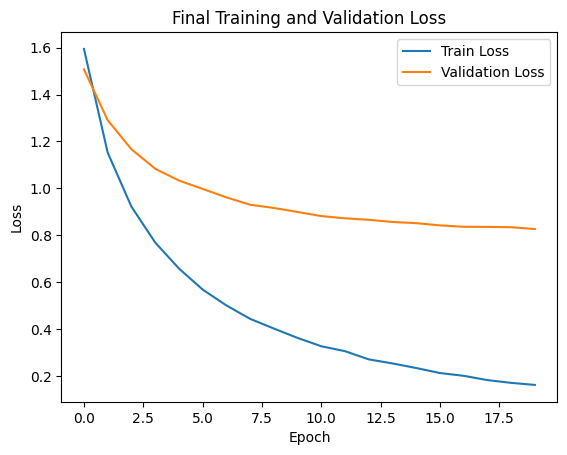

In [14]:
# Retrieve best hyperparameters from the Optuna study
best_params = study.best_params
best_lr = best_params['lr']
best_momentum = best_params['momentum']
best_batch_size = best_params['batch_size']

# Create DataLoaders using the best batch size
train_loader, val_loader = get_data_loaders(best_batch_size)

# Reinitialize the model
resnet18_model = resnet18(pretrained=True)
for param in resnet18_model.parameters():
    param.requires_grad = False
for param in resnet18_model.layer3.parameters():
    param.requires_grad = True
for param in resnet18_model.layer4.parameters():
    param.requires_grad = True
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, num_classes)
resnet18_model = resnet18_model.to(device)

# Define the optimizer and criterion
best_optimizer = optim.SGD(resnet18_model.parameters(), lr=best_lr, momentum=best_momentum)
criterion = nn.CrossEntropyLoss()

# Train the model with the best hyperparameters
print("Training ResNet-18 with best hyperparameters...")
final_train_losses, final_val_losses = train_model(
    resnet18_model, train_loader, val_loader, criterion, best_optimizer, device, epochs=20, patience=5
)

# Plot final training and validation loss curves
plt.plot(final_train_losses, label='Train Loss')
plt.plot(final_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final Training and Validation Loss')
plt.legend()
plt.show()

# After training

ResNet-18 Metrics:
Accuracy: 81.03%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.94      0.93      0.93        81
       glass       0.67      0.98      0.79       100
       metal       0.84      0.89      0.86        82
       paper       0.81      0.97      0.89       119
     plastic       0.98      0.49      0.66        97
       trash       0.00      0.00      0.00        27

    accuracy                           0.81       506
   macro avg       0.71      0.71      0.69       506
weighted avg       0.80      0.81      0.78       506



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


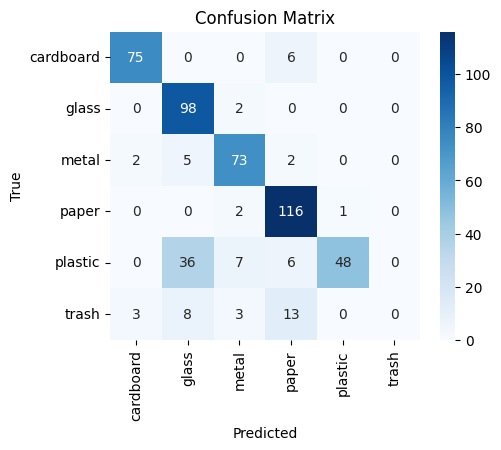

In [15]:
# Evaluate ResNet-18
print("ResNet-18 Metrics:")
resnet18_accuracy_after, resnet18_report_after, resnet18_cm_after = evaluate_model(resnet18_model, test_loader, device, classes)

# # Evaluate MobileNet_v2
# print("\nMobileNet_v2 Metrics:")
# mobilenet_v2_accuracy_after, mobilenet_v2_report_after, mobilenet_v2_cm_after = evaluate_model(mobilenet_v2_model, test_loader, device, classes)

# # Evaluate EfficientNet_B0
# print("\nEfficientNet_B0 Metrics:")
# efficientnet_b0_accuracy_after, efficientnet_b0_report_after, efficientnet_b0_cm_after = evaluate_model(efficientnet_b0_model, test_loader, device, classes)


In [16]:
# Store results for comparison
# results = {
#     "ResNet-18": {
#         "Before Training": {"Accuracy": resnet18_accuracy_before},
#         "After Training": {"Accuracy": resnet18_accuracy_after},
#     },
#     "MobileNet_v2": {
#         "Before Training": {"Accuracy": mobilenet_v2_accuracy_before},
#         "After Training": {"Accuracy": mobilenet_v2_accuracy_after},
#     },
#     "EfficientNet_B0": {
#         "Before Training": {"Accuracy": efficientnet_b0_accuracy_before},
#         "After Training": {"Accuracy": efficientnet_b0_accuracy_after},
#     },
# }

results = {
    "ResNet-18": {
        "Before Training": {"Accuracy": resnet18_accuracy_before},
        "After Training": {"Accuracy": resnet18_accuracy_after},
    }
}

# Print the summarized results
for model, accuracy in results.items():
    print(f"\n{model} Results:")
    print(f"  Before Training Accuracy: {accuracy['Before Training']['Accuracy']:.2f}%")
    print(f"  After Training Accuracy: {accuracy['After Training']['Accuracy']:.2f}%")



ResNet-18 Results:
  Before Training Accuracy: 15.02%
  After Training Accuracy: 81.03%


ResNet-18 Misclassifications:


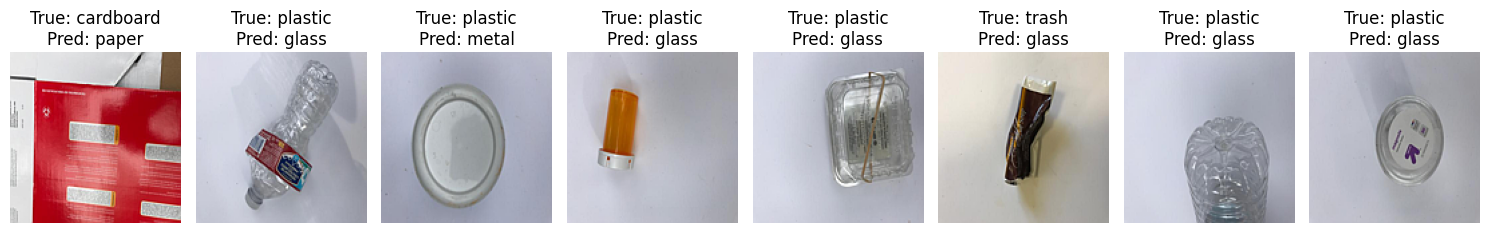

In [17]:
def visualize_misclassifications(model, data_loader, device, classes, num_images=8):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))
                    if len(misclassified) >= num_images:
                        break
            if len(misclassified) >= num_images:
                break

    # Handle case with fewer misclassifications
    num_to_plot = min(len(misclassified), num_images)

    # Plot misclassified images
    fig, axes = plt.subplots(1, num_to_plot, figsize=(15, 5))
    if num_to_plot == 1:
        axes = [axes]  # Handle single subplot case
    for ax, (img, true_label, pred_label) in zip(axes, misclassified):
        img = img / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize for ResNet-18
print("ResNet-18 Misclassifications:")
visualize_misclassifications(resnet18_model, test_loader, device, classes, num_images=8)


In [19]:
import os
import json
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a symbolic link for easier access
!ln -s "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Experimentation_3" /content/Experimentation_3
print("Symbolic link created: /content/Experimentation_3")

# Define the path to the Results folder
folder_path = '/content/Experimentation_3/Results'

# Create the Results folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)
print(f"Folder created (or already exists) at: {folder_path}")

# Define the path for the JSON file for Version 3
json_file_path = os.path.join(folder_path, "model_results_v3.json")

# Save the results as Version 3
try:
    with open(json_file_path, "w") as f:
        json.dump(results, f, indent=4)
    print(f"Version 3 Results saved to: {json_file_path}")
except NameError:
    print("Error: The 'results' dictionary is not defined. Ensure you have results from your experiments.")


Mounted at /content/drive
Symbolic link created: /content/Experimentation_3
Folder created (or already exists) at: /content/Experimentation_3/Results
Version 3 Results saved to: /content/Experimentation_3/Results/model_results_v3.json
